# Input PC bounding box allignment

After successfully aligning the cuboid by projecting the respective edges/ sides onto the axes, now the final test will be performed with the bounding box of the input point cloud.

## Imports

In [160]:
# For paths
import os 

# For data processing
import numpy as np

# For 3D visualization
import open3d as o3d
import matplotlib.pyplot as plt

## Functions

These are the respective functions used within this notebook to make the code more readable and also to standardize certain procedures and avoid unnecessary and unclean code reptitions.

In [229]:

# Setting the root for this repo
ROOT = os.path.realpath("..")

# Creating/ Making the point cloud
def makePC(point_data, color_data=np.array([])):
    pcd = o3d.geometry.PointCloud() #Create PC object
    pcd.points = o3d.utility.Vector3dVector(point_data) #Give coordinates
    #Coloring the PC
    if len(color_data) == 0:
        pcd.paint_uniform_color([1, 0, 0])
    else:
        pcd.colors = o3d.utility.Vector3dVector(color_data)
    return pcd

# Retrieve lowest corner fo the cuboid/ bounding box
def get_lowest_corner_coords(cuboid_coords, axis):
    ''' 
    inputs:
    - cuboid_coords: 8x3-array of cuboid vertice coordinates
    - axis: string determining in which direction one wants to retrieve the "lowest corner"
    
    return:
    - lowest_corner_coords: 1x3-array with the coordinates of the "lowest" corner in the specified direction
    '''
    if axis == 'z':
        z_val_lowest_corner = np.min(cuboid_coords[:,2])
        # Correction in the case there are several corners with the same value
        if len(np.where(cuboid_coords == z_val_lowest_corner)) == 1:
            lowest_corner_idx = int(np.where(cuboid_coords == z_val_lowest_corner)[0])
        else:
            lowest_corner_idx = int(np.where(cuboid_coords == z_val_lowest_corner)[0][0])
        lowest_corner_coords = cuboid_coords[lowest_corner_idx]
    elif axis == 'y':
        y_val_lowest_corner = np.min(cuboid_coords[:,1])
        # Correction in the case there are several corners with the same value
        if len(np.where(cuboid_coords == y_val_lowest_corner)) == 1:
            lowest_corner_idx = int(np.where(cuboid_coords == y_val_lowest_corner)[0])
        else:
            lowest_corner_idx = int(np.where(cuboid_coords == y_val_lowest_corner)[0][0])
        lowest_corner_coords = cuboid_coords[lowest_corner_idx]
    elif axis == 'x':
        x_val_lowest_corner = np.min(cuboid_coords[:,0])
        # Correction in the case there are several corners with the same value
        if len(np.where(cuboid_coords == x_val_lowest_corner)) == 1:
            lowest_corner_idx = int(np.where(cuboid_coords == x_val_lowest_corner)[0])
        else:
            lowest_corner_idx = int(np.where(cuboid_coords == x_val_lowest_corner)[0][0])
        lowest_corner_coords = cuboid_coords[lowest_corner_idx]
    return lowest_corner_coords

# Create norm of passed vector
def norm_vec(vector):
    '''
    input:
    - vector: 1x3-array of vector to be normed
    
    return:
    - vector norm
    '''
    return np.linalg.norm(vector)

# Creating unit vector for input vector
def unit_vector(vector):
    '''
    input:
    - vector: 1x3-array of vector to be unitized
    
    output:
    - 1x3-array of unit vector from passed vector
    '''
    return vector / np.linalg.norm(vector)

# Create vector array of start and end point array
def create_vectors(start_end_point_array):
    '''
    This function returns an array of 3D vectors from a start and end point array.
    
    input:
    - start_end_point_array: array of starting and end points of vectors
    
    return:
    - vec_return: array of 3D vectors
    '''
    # Creation of empty vector list to be filled
    vec_return = np.zeros((len(start_end_point_array), 3))
    for i in range(len(start_end_point_array)):
        vec_i = start_end_point_array[i][1] - start_end_point_array[i][0]
        vec_return[i] = vec_i
    return vec_return

# Create ascendingly sorted vector distances array
def create_vec_distances(vectors):
    '''
    input:
    - vectors: coordinates of vectors whose distances shall be calculated
    
    return:
    - vector_dists: vector distances
    '''
    vector_dists_list = []
    for i in range(len(vectors)):
        vector_i_dist = norm_vec(vectors[i])
        vector_dists_list.append(vector_i_dist)
    vector_dists = np.array(vector_dists_list)
    return vector_dists

def get_orthonormal_vec_coords(orthonnormal_vec_coords, which):
    '''
    inputs:
    - orthogonal_vec_coords: coordinates of the 3 orthonormal vectors
    - which: string-argument specifying which of the orthonormal vector coordinates to be retrieved
        - longest: x-edge of the bounding box
        - middle: y-edge of the bounding box
        - shortest: z-edge of the bounding box
    
    return:
    - dist_sorted_orthogonal_vec_coords[i]: 1x3-array of corresponding orthonormal vector
    '''
    orthogonal_vec_dists = create_vec_distances(orthonnormal_vec_coords)
    # Sort coordinate list as the distance list 
    dist_sorted_indices = orthogonal_vec_dists.argsort()
    dist_sorted_orthognal_vec_coords = orthonnormal_vec_coords[dist_sorted_indices]
    if which == 'longest':
        return dist_sorted_orthognal_vec_coords[2]
    elif which == 'middle':
        return dist_sorted_orthognal_vec_coords[1]
    elif which == 'shortest':
        return dist_sorted_orthognal_vec_coords[0]
    else:
        print('Argument -which- was specified incorrectly, please correct.')

# Find R for aligning vec1 with vec2
def rot_mat_from_vecs(vec1, vec2):
    '''
    Find rotation matrix aligning vec1 with vec 2 (based in Rodrigues' rotation formula)
    
    inputs:
    - vec1: vector to be aligned | 1x3-array
    - vec2: vector to be aligned with | 1x3-array
    
    return:
    - rot_mat: rotation matrix rotating vec1 onto vec2
    '''
    vec1_uv, vec2_uv = unit_vector(vec1).reshape(3), unit_vector(vec2).reshape(3)
    v = np.cross(vec1_uv, vec2_uv)
    c = np.dot(vec1_uv, vec2_uv)
    s = norm_vec(v)
    kmat = np.array([[0, -v[2], v[1]], 
                     [v[2], 0, -v[0]],
                     [-v[1], v[0], 0]])
    rot_mat = np.eye(3) + kmat + kmat.dot(kmat) * ((1-c) / (s**2))
    return rot_mat

# Rotate coordinates with rotation amtrix for axis alignment
def rotate_coords_onto_axis(coords, R):
    ''' 
    Function that rotates the given points by the given rotation matrix.
    
    input:
    - coords: coordinates of points to be rotated
    - R: rotation amtrix by which the points should be rotated
    
    return:
    coords_rot: rotated point coordinates
    '''
    # Depending on shape of coordinates passed rotation multiplication adjustment
    if coords.shape == (3,):
        coords_rot = R.dot(coords)
    coords_rot_list = []
    for i in range(len(coords)):
        coords_i_rot = R.dot(coords[i])
        coords_rot_list.append(coords_i_rot)
    coords_rot = np.array(coords_rot_list)
    return coords_rot

# Input PC

In order to better check whether the rotation was successful, we will display the point cloud in matplotlib, as it is not an interactive view, in which the cloud can be rotated and moved to investigate.

## Visualization of raw input pc

Below you can find the visualizaiton of the original input point cloud, with its original orientation and coordinates.

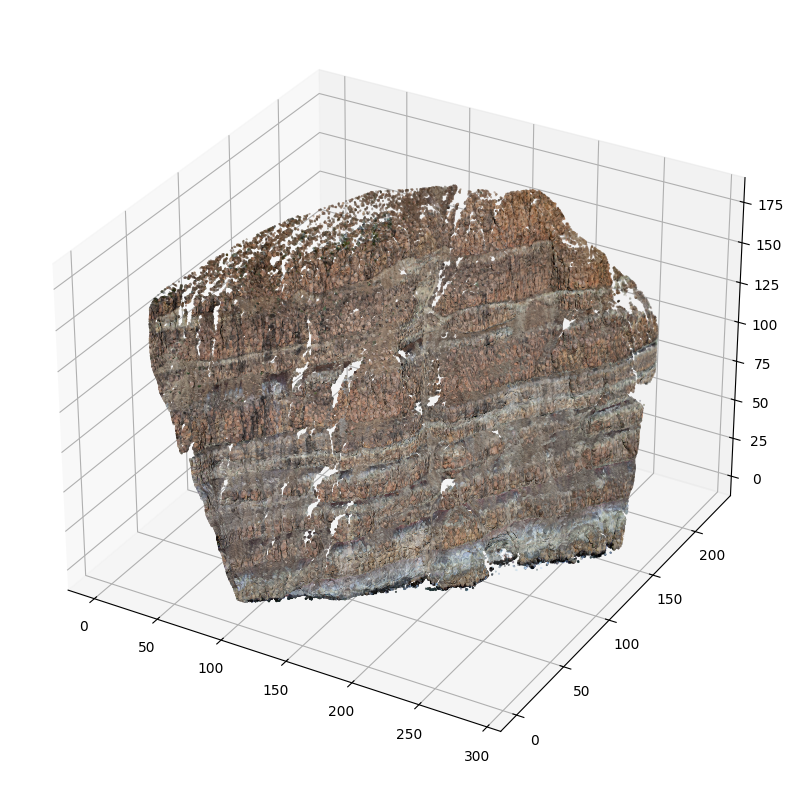

In [163]:
# Path to input data
input_data_path = ROOT + "/data/testdata/data_labelled_int.npy"

# Load the input data
input_pc = np.load(input_data_path)

# Assigning xyz values
x_original = input_pc[:,0]
y_original = input_pc[:,1]
z_original = input_pc[:,2]
# Creating entire coords array for rotation
input_pc_coords = input_pc[:, 0:3]
# Assigning color channels
red_c = input_pc[:, 3]
green_c = input_pc[:, 4]
blue_c = input_pc[:, 5]
#Shifting color range ot be between [0, 1]
red_c = (red_c - np.min(red_c)) / (np.max(red_c) - np.min(red_c))
green_c = (green_c - np.min(green_c)) / (np.max(green_c) - np.min(green_c))
blue_c = (blue_c - np.min(blue_c)) / (np.max(blue_c) - np.min(blue_c))
# Creating individual color arrray
rgb_list = np.ones((input_pc.shape[0], 3))
rgb_list[:, 0] = red_c
rgb_list[:, 1] = green_c
rgb_list[:, 2] = blue_c 

# Visualization
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x_original, y_original, z_original, c=rgb_list, s=0.1)
plt.show()

## Investigation of the bounding box

In order for the method as it was developed to work, the assumption is that the bounding box is a cuboid with orthonormal corners and parallell edges.

In [165]:
# Stacking coordinates of input pc
input_pc_coords = np.stack([x_original, y_original, z_original], axis=1)

# Making point cloud to be displayed
viz_pc = makePC(input_pc_coords, rgb_list)

# Cropping pc with oriented bounding box
bbox_to_crop = viz_pc.get_oriented_bounding_box()
bbox_color = (0, 1, 0)
viz_pc_cropped = viz_pc.crop(bbox_to_crop)
bbox_original = viz_pc_cropped.get_oriented_bounding_box()

# Get bounding box corner points
bbox_points = np.round(np.asarray(bbox_original.get_box_points()), 2)

print(bbox_points)

[[ -5.31  64.63 208.5 ]
 [258.93 243.15 179.07]
 [ 56.44 -57.09  24.6 ]
 [-28.    93.78 181.58]
 [298.   150.57 -31.74]
 [ 33.75 -27.95  -2.31]
 [236.24 272.3  152.16]
 [320.68 121.43  -4.83]]


Now we have the 8 corner points and their 3D-coordinates. We now go on and choose the lowest point (in z-direction) from which we will construct the vectors to the others.

In [166]:
# retrieving lowest corner in z-direction
lowest_corner_coords = get_lowest_corner_coords(bbox_points, axis='z')

# Construction of vectors to all other points
lowest_corner_to_corner_vectors_list = []
for i in range(len(bbox_points)):
    vec_i = bbox_points[i] - lowest_corner_coords
    # Skip vec to same corner as lowest
    if (vec_i == np.array([0, 0, 0])).all():
        continue
    lowest_corner_to_corner_vectors_list.append(vec_i)
lowest_corner_to_corner_vectors = np.array(lowest_corner_to_corner_vectors_list)

# Determining distances ot choose the shortest to be aligned with z-axis
lowest_corner_to_corner_dists = create_vec_distances(lowest_corner_to_corner_vectors)
shortest_idx = np.argmin(lowest_corner_to_corner_dists)
shortest_lowest_corner_to_corner_vector_coords = lowest_corner_to_corner_vectors[shortest_idx]

# Calculating the dot product to find orthonormal vecs
orthonormal_vec_coords_list = []
for i in range(len(lowest_corner_to_corner_vectors)):
    dot_product_result = np.dot(
        unit_vector(shortest_lowest_corner_to_corner_vector_coords),
        unit_vector(lowest_corner_to_corner_vectors[i])
    )
    if np.round(dot_product_result, 2) <= 0.00001:
        orthonormal_vec_coords_list.append(lowest_corner_to_corner_vectors[i])

# Filtering out the longest orthogonal vector adn replace with the shortest
orthonormal_vec_dists = create_vec_distances(orthonormal_vec_coords_list)
longest_idx = np.argmax(orthonormal_vec_dists)
del orthonormal_vec_coords_list[longest_idx]
orthonormal_vec_coords_list.append(shortest_lowest_corner_to_corner_vector_coords)
orthonormal_vec_coords = np.array(orthonormal_vec_coords_list)

Below we will just print out the orthonormal vector coordinates to check whether the operation at least theoretically was successfull (we shuold have three vectors with three directional components in 3D).

In [167]:
orthonormal_vec_coords

array([[-264.25, -178.52,   29.43],
       [ -61.76,  121.73,  183.9 ],
       [  22.68,  -29.14,   26.91]])

### Plotting selected orthonormal vectors

Just for a visual double check, we will plot the orthonormal vector trio on the origin to see whether they are orthonormal and directionally make sense.

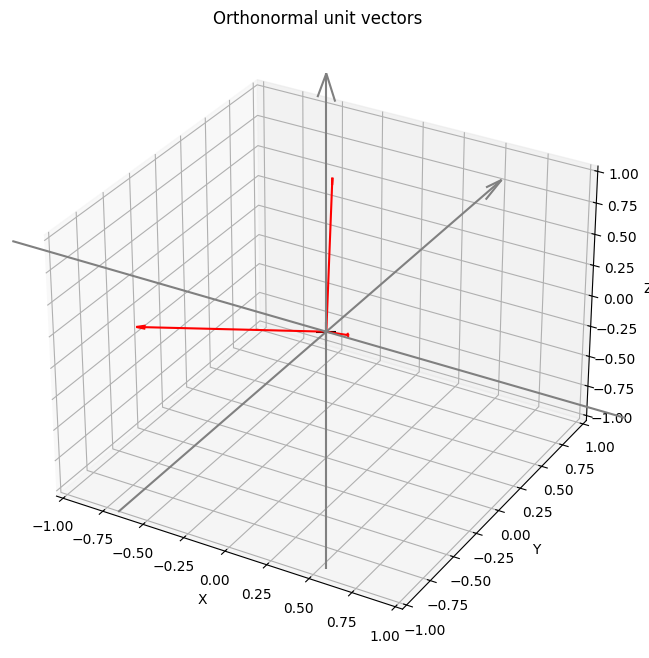

In [168]:
# Creation of figure and subplot for plotting
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
plt.title("Orthonormal unit vectors")

# Origin
ax.scatter( xs=0,
            ys=0,
            zs=0,
            marker='+', 
            c='black', 
            s=200)

# Axes - as quivers in grey
x_start = [-2, 0, 0]
y_start = [0, -2, 0]
z_start = [0, 0, -2]
axes_start = np.vstack((x_start, 
                        y_start, 
                        z_start))
x, y, z = axes_start[:,0], axes_start[:,1], axes_start[:,2]
x_vec = [4, 0, 0]
y_vec = [0, 4, 0]
z_vec = [0, 0, 4]
axes_vec = np.vstack((x_vec, 
                    y_vec, 
                    z_vec))
u, v, w = axes_vec[:,0], axes_vec[:,1], axes_vec[:,2]
ax.quiver(x, y, z, u, v, w,
        arrow_length_ratio=0.05, 
        color='grey')

# Orthonormal vector trio plot
x, y, z = np.zeros(3), np.zeros(3), np.zeros(3)
# Creating unit vectors for plotting
orthonormal_unit_vecs_list = []
for i in range(len(orthonormal_vec_coords)):
    unit_vec_i = unit_vector(orthonormal_vec_coords[i])
    orthonormal_unit_vecs_list.append(unit_vec_i)
orthonormal_unit_vecs = np.array(orthonormal_unit_vecs_list)
u, v, w = orthonormal_unit_vecs[:,0], orthonormal_unit_vecs[:,1], orthonormal_unit_vecs[:,2]
ax.quiver(x, y, z, u, v, w,
        arrow_length_ratio=0.05, 
        color='red')

# Limits for display
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

# Axes Description
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

# First Rotation

Now that we finally have the orthonormal vector trio we will start with the vector projections. The first projection/ rotation is aligning the shortest edge with the z-axis.

In [169]:
# Pulling coordinates of the shortest orthonormal vector
z_edge = get_orthonormal_vec_coords(orthonormal_vec_coords, 'shortest')

# Retrieving the rotation matrix to align with z-axis
R_rot1 = rot_mat_from_vecs(z_edge, np.array([0, 0, 1]))

# Rotating the points
input_pc_rot1 = rotate_coords_onto_axis(input_pc_coords, R_rot1)
# Rotating orthonormal vectors
orthonormal_vec_coords_rot1 = rotate_coords_onto_axis(orthonormal_vec_coords, R_rot1)

### Visualization of first rotation

From the first rotation, which we align with the z-axis, we expect the point cloud to now "lie flat" in space. Due to the rigid visualization via matplotlib, the visualization of that orientation might look a little weird from the perspective, but should already give a hint whether it has been performed correclty.

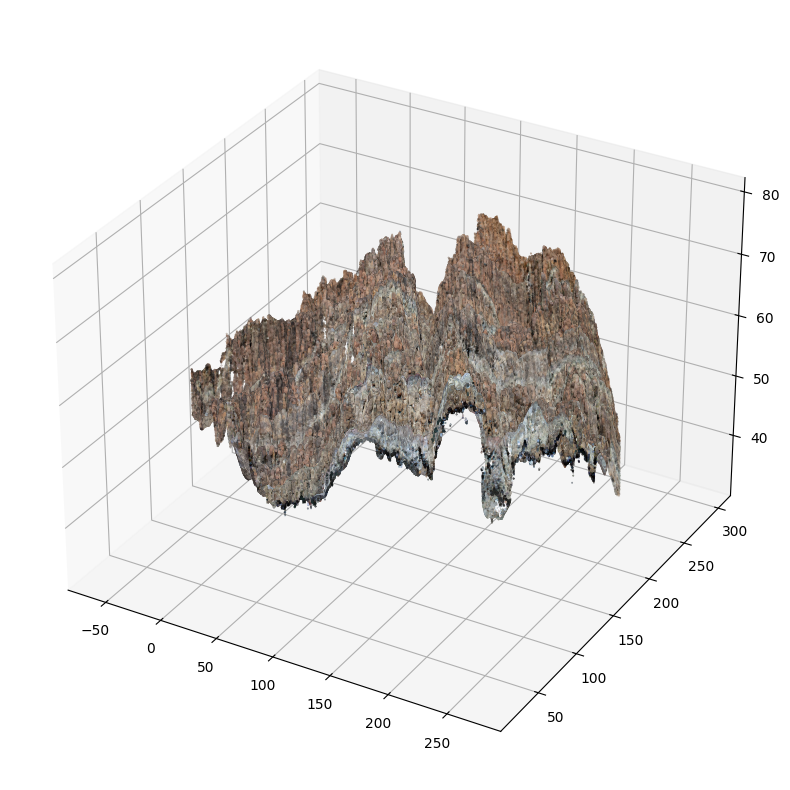

In [170]:
# Assigning xyz values
x_rot1 = input_pc_rot1[:,0]
y_rot1 = input_pc_rot1[:,1]
z_rot1 = input_pc_rot1[:,2]

# Visualization
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x_rot1, y_rot1, z_rot1, c=rgb_list, s=0.1)
plt.show()

### Display of both PC's in open3d

Unfortunately, it doesnt really show anything that is interpretable....

In [171]:
# # Making point cloud to be displayed
# viz_pc_rot1 = makePC(input_pc_rot1, rgb_list)

# # Visualization of both PC's
# o3d.visualization.draw([viz_pc_cropped, viz_pc_rot1])

# Second Rotation

Following the first rotation, a second rotation is needed to align the bounding box/ point cloud with the other axes. As a second rotation we will now rotate the point cloud, so that the longest edge of the bounding box is aligned with the x-axis of the coordinate system.

In [172]:
# Pulling coordinates of the shortest orthonormal vector
x_edge = get_orthonormal_vec_coords(orthonormal_vec_coords_rot1, 'longest')

# Retrieving the rotation matrix to align with z-axis
R_rot2 = rot_mat_from_vecs(x_edge, np.array([1, 0, 0]))

# Rotating the points
input_pc_rot2 = rotate_coords_onto_axis(input_pc_rot1, R_rot2)
# Rotating orthonormal vectors
orthonormal_vec_coords_rot2 = rotate_coords_onto_axis(orthonormal_vec_coords_rot1, R_rot2)

### Visualization of second rotation

Again, because of the rigid perspective, it might not look intuitive, but should give a good hint whether things happened as we wish.

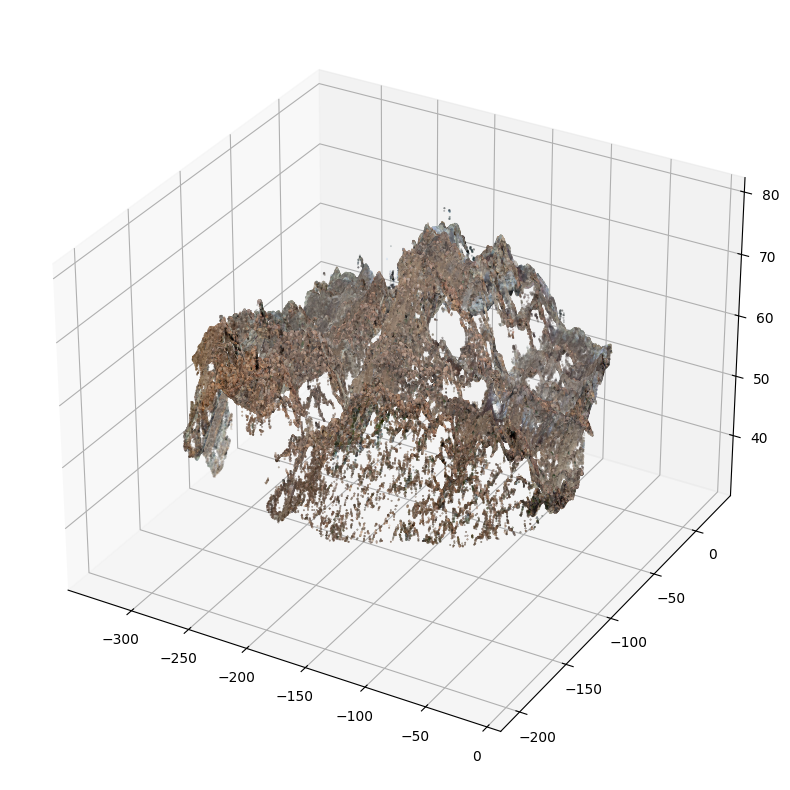

In [173]:
# Assigning xyz values
x_rot2 = input_pc_rot2[:,0]
y_rot2 = input_pc_rot2[:,1]
z_rot2 = input_pc_rot2[:,2]

# Visualization
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x_rot2, y_rot2, z_rot2, c=rgb_list, s=0.1)
plt.show()

# Centering Final rotated PC

After now having sucessfully rotated the point cloud, the last step will be to centr the given point cloud on the origin, which basically just means to substract the center of the point coud from all points.

In [174]:
# Define center of the point cloud
pc_center = np.mean(input_pc_rot2, axis=0)

# Centering the pc
input_rot2_centered = input_pc_rot2 - pc_center

### Visualization of final centered rotated PC

This visualization itslef should not change, as the point cloud wa smerely translated to a different location, but the axis descriptions shuold have adjusted so that the final rotated point cloud appears to be centered around the origin.

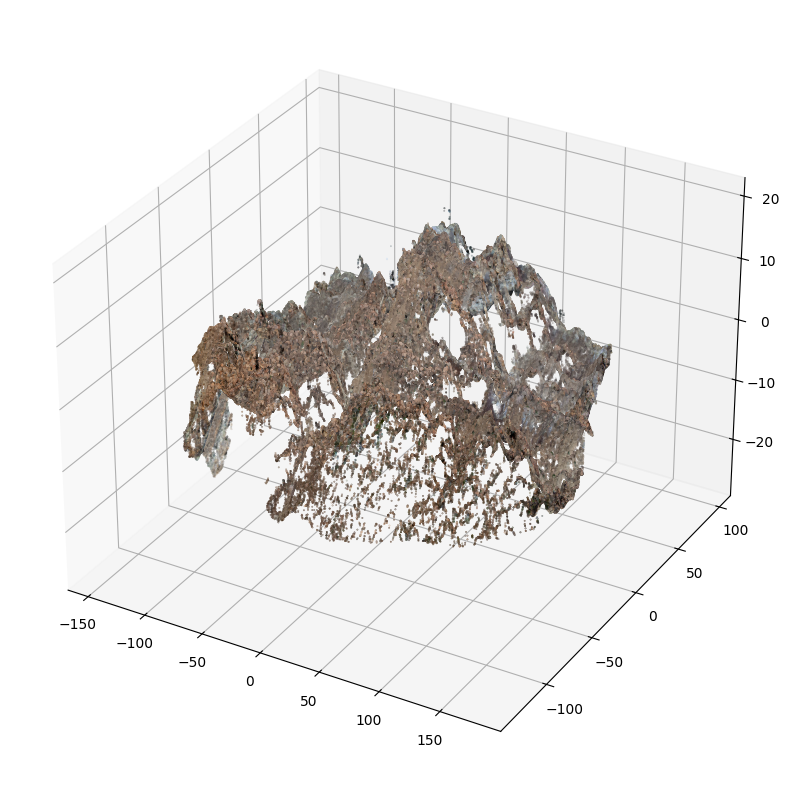

In [175]:
# Assigning xyz values - c for centered
x_c = input_rot2_centered[:,0]
y_c = input_rot2_centered[:,1]
z_c = input_rot2_centered[:,2]

# Visualization
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x_c, y_c, z_c, c=rgb_list, s=0.1)
plt.show()

# Visualization of first and last PC

In order to have a better overview and check of whether the rotation worked as we wished, below you can find the visualization of the original point cloud and the rotated point cloud in one figure. Don't let the scale of the axes or the perspective fool you, but this should come out pretty much as we imagined. Subsequently, we will check that the ratation of the point cloud has not lead to any difference in scaling etc. 

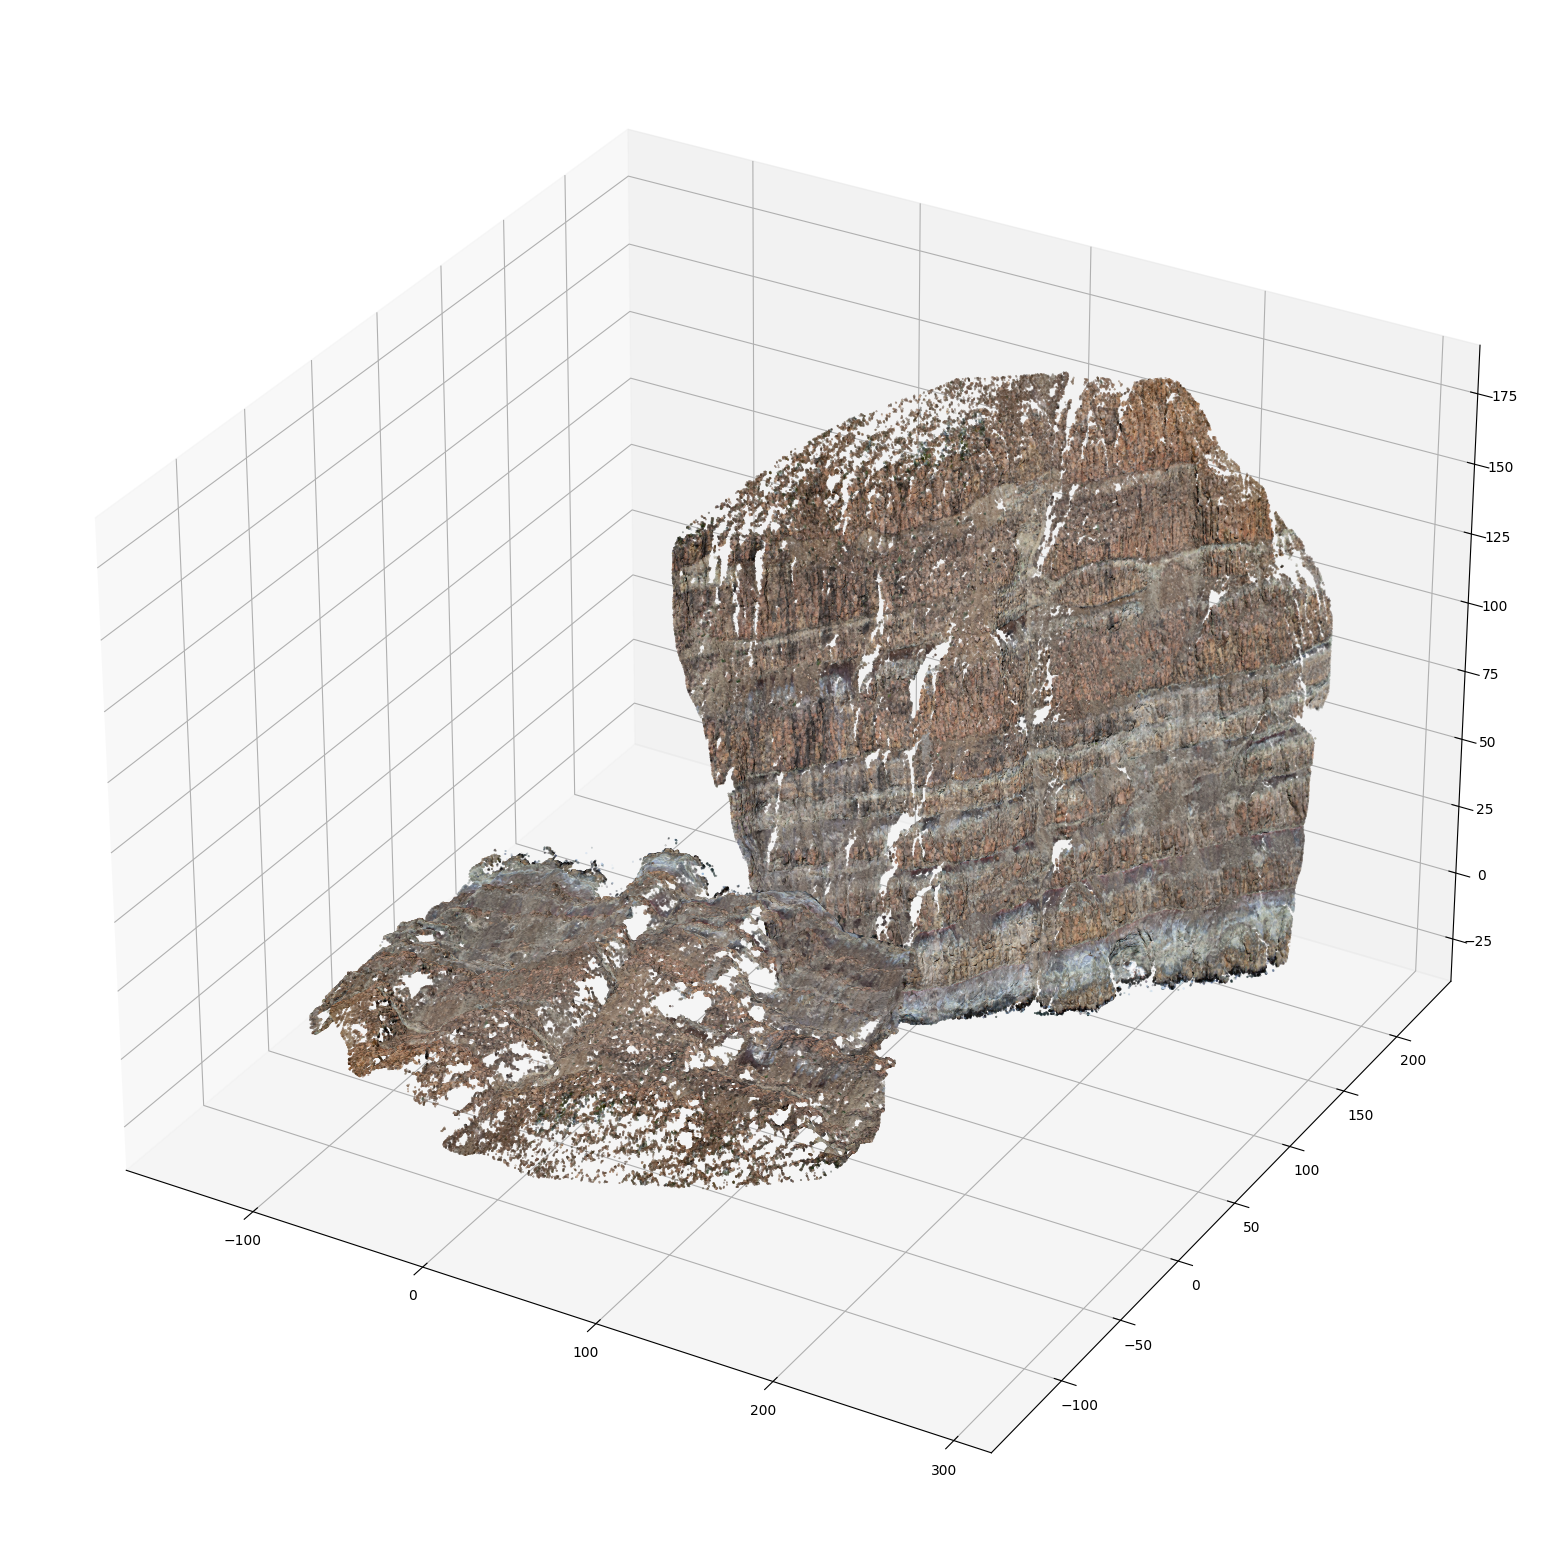

In [176]:
# Visualization
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x_original, y_original, z_original, c=rgb_list, s=0.1)
ax.scatter(x_c, y_c, z_c, c=rgb_list, s=0.1)
plt.show()

# Comparison of width and height

To make sure its only rotated and transformed and not scaled, we will now take a look at the width and height of the point cloud to get a feeling whether anything changed there. In order to analyze this in the best way, we will compare the length of the bounding box lines to see whether the size of the bounding box has changed, as the minimum and maximum values give little meaning depending on their rotation.

In [230]:
# LineSet of the initial bounding box of the input pc 
original_bbox_lineset = o3d.geometry.LineSet.create_from_oriented_bounding_box(bbox_original)
# Create empty array for linepoints
original_bbox_line_points = np.zeros((12, 2, 3))
# Fetch the lines from the lineset object (start point - end point)
for i in range(12):
    line_i = original_bbox_lineset.get_line_coordinate(i)
    original_bbox_line_points[i][0] = line_i[0]
    original_bbox_line_points[i][1] = line_i[1]

# Create PC of rotated points
rot_centered_pc = makePC(input_rot2_centered[:,0:3], rgb_list)
# get oriented bounding box
rotated_bbox = rot_centered_pc.get_oriented_bounding_box()
# Get the lineset of bounding box of rotated points
rotated_bbox_lineset = o3d.geometry.LineSet.create_from_oriented_bounding_box(rotated_bbox)
# Create empty array for linepoints
rotated_bbox_line_points = np.zeros((12, 2, 3))
# Fetch the lines from the lineset object (start point - end point)
for i in range(12):
    line_i = rotated_bbox_lineset.get_line_coordinate(i)
    rotated_bbox_line_points[i][0] = line_i[0]
    rotated_bbox_line_points[i][1] = line_i[1]

# Create vectors for all the lines
original_bbox_edge_vecs = create_vectors(original_bbox_line_points)
rotated_bbox_edge_vecs = create_vectors(rotated_bbox_line_points)

# Create distances for the bounding box edge vectors
original_bbox_edge_dists = create_vec_distances(original_bbox_edge_vecs)
rotated_bbox_edge_dists = create_vec_distances(rotated_bbox_edge_vecs)

In [231]:
original_bbox_edge_dists

array([320.24984367, 229.01561509, 320.24984367, 229.01561509,
       320.24984367, 229.01561509, 320.24984367, 229.01561509,
        45.69926304,  45.69926304,  45.69926304,  45.69926304])

In [232]:
rotated_bbox_edge_dists

array([320.47304012, 229.10452243, 320.47304012, 229.10452243,
       320.47304012, 229.10452243, 320.47304012, 229.10452243,
        46.14550012,  46.14550012,  46.14550012,  46.14550012])

After careful inspection of the distances we can see that there should be 3 sets of 4 lines of the same length for each set, and the difference between the respective distances of these linsets is supposed to be minimal. Following the values that have been printed out for the line distances, we can conclude, that the point cloud was only rotated and not scaled in any way during the process. Therefore, this process of rotating and adjusting the point cloud before blocking is working correctly and can be implemented.

# Conclusion

To conclude the efforts in this notebook, we can say that mapping the bounding box edges onto the respective axes does rotate the point cloud as we want. Therefore, this rotation procedure will be implemented for the input point clouds, so the blocking can take place as we expect it as well. The blocking of the rotated input point cloud will be the focus of the next notebook.